# Extractive Text Summarization

## Text Summarization with TF-IDF

High-level outline:
- Split the document into sentences
- Score each sentence
- Rank each sentence by those scores
- Summary = top scoring sentences


The pipeline for scoring sentences is: 
- Sentence tokenization (splitting document into sentences) can be done with NLTK (`nltk.sent_tokenize(your_text)`)
- Build TF-IDF matrix, treating each sentence *as if* they were documents
We don't need a whole dataset of documents, only the document we want to summarize!


The scoring pipleni is:

- Score = Average(non-zero TF-IDF values)
- E.g. if row = [0, 1, 0, 0, 0, 2, 3, 0, 0, 0, ...] then score = avg(1,2,3) = 2

Each TF-IDF component tells us how often a word appears (TF)

But if a word appears across many sentences, it will shrink (IDF)

Important words will have a larger score

Why mean and not sum?

The sum would be biased toward longer sentences

Why only the non-zero values?

TF-IDF matrix is sparse (don't want to choose based on variety of words)

In [1]:
# !pip install datasets

In [52]:
import pandas as pd
import numpy as np
import nltk
import textwrap
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset

In [53]:
# dataset = load_dataset("permutans/fineweb-bbc-news", "CC-MAIN-2023-50", split="train")

In [54]:
dataset = load_dataset("SetFit/bbc-news", split="train")

In [55]:
dataset

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 1225
})

In [56]:
print(dataset['text'][2])

rock band u2 break ticket record u2 have smashed irish box office records with ticket sales for their dublin concerts  after more than 150 000 were sold within 50 minutes.  tickets for the two concerts at the city s croke park stadium were released at 8am on friday morning.  nothing like it has ever been seen in ireland before   said justin green  spokesman for organisers mcd promoters.  we could have sold a million tickets.  the dublin dates on june 24 and 25 form part of the worldwide vertigo tour. the tour begins in san diego on 28 march and will cover 13 us cities. the band will also play 24 european gigs  finishing in lisbon in august.  mr green said that ticket outlets had been  bombarded  by u2 fans.  unfortunately there s thousands and thousands of disappointed fans all over the country which is disappointing  but there s only two dates confirmed   he said. many fans camped on the streets of the irish capital for three days to ensure they were first in line at ticketmaster in s

In [57]:
print(textwrap.fill(dataset['text'][2], replace_whitespace=False, fix_sentence_endings=True))

rock band u2 break ticket record u2 have smashed irish box office
records with ticket sales for their dublin concerts  after more than
150 000 were sold within 50 minutes.  tickets for the two concerts at
the city s croke park stadium were released at 8am on friday morning.
nothing like it has ever been seen in ireland before   said justin
green  spokesman for organisers mcd promoters.  we could have sold a
million tickets.  the dublin dates on june 24 and 25 form part of the
worldwide vertigo tour.  the tour begins in san diego on 28 march and
will cover 13 us cities.  the band will also play 24 european gigs
finishing in lisbon in august.  mr green said that ticket outlets had
been  bombarded  by u2 fans.  unfortunately there s thousands and
thousands of disappointed fans all over the country which is
disappointing  but there s only two dates confirmed   he said.  many
fans camped on the streets of the irish capital for three days to
ensure they were first in line at ticketmaster in 

In [58]:
article = dataset['text'][2]

In [59]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [60]:
sentences = nltk.sent_tokenize(article)

In [61]:
print(sentences[0])

rock band u2 break ticket record u2 have smashed irish box office records with ticket sales for their dublin concerts  after more than 150 000 were sold within 50 minutes.


In [62]:
print(sentences[1])

tickets for the two concerts at the city s croke park stadium were released at 8am on friday morning.


In [63]:
featurizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    norm='l1',
)

In [64]:
X = featurizer.fit_transform(sentences)

In [65]:
def score_sentence(tfidf_row):
  x = tfidf_row[tfidf_row != 0]
  return x.mean()

In [66]:
scores = np.zeros(len(sentences))
for i in range(len(sentences)):
  score = score_sentence(X[i,:])
  scores[i] = score

In [69]:
sort_idx = np.argsort(-scores)

In [70]:
def wrap(x):
  return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

In [71]:
for i in sort_idx[:10]:
  print(wrap(f"{scores[i]}: {sentences[i]}"))

0.25: we could have sold a million tickets.
0.125: mr green said that ticket outlets had been  bombarded  by u2
fans.
0.11111111111111109: the band will also play 24 european gigs
finishing in lisbon in august.
0.1: the dublin dates on june 24 and 25 form part of the worldwide
vertigo tour.
0.1: however the majority of tickets  priced at between 59.50 and 80
euro each  were sold online.
0.09999999999999999: the tour begins in san diego on 28 march and will
cover 13 us cities.
0.09999999999999999: unfortunately there s thousands and thousands of
disappointed fans all over the country which is disappointing  but
there s only two dates confirmed   he said.
0.09090909090909088: tickets for the two concerts at the city s croke
park stadium were released at 8am on friday morning.
0.08333333333333333: nothing like it has ever been seen in ireland
before   said justin green  spokesman for organisers mcd promoters.
0.05263157894736843: earlier this week  bono announced that the band
would play 

## Page Rank

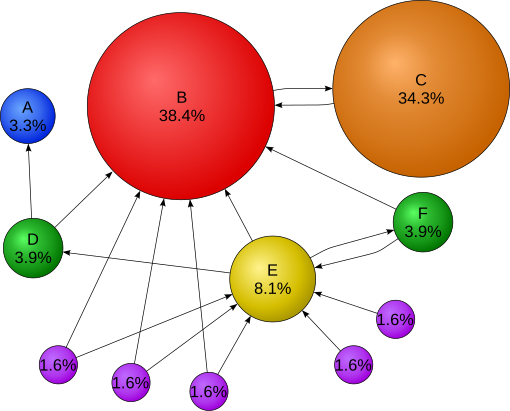

# PageRank Explanation

## The Random Walk Concept

PageRank is based on simulating how a random web surfer would navigate the internet:

- **Start anywhere**: Begin at any random webpage
- **Follow links randomly**: At each page, randomly click on one of the outgoing links
- **Repeat indefinitely**: Continue this process forever

## The Magic of Convergence

After running this random walk for a sufficiently long time, something remarkable happens:

- **Steady-state probability**: The probability of being on any particular page converges to a constant value
- **Independence from start**: This final probability distribution is the same regardless of which page you started from
- **PageRank score**: This steady-state probability becomes each page's PageRank score

## Why It Works

The intuition behind PageRank:

- **Popular pages get more visits**: Pages with many incoming links will be visited more often during the random walk
- **Quality matters**: Links from important pages (those with high PageRank themselves) count more than links from less important pages
- **Democratic voting**: Each page "votes" for the pages it links to, with its vote weight proportional to its own importance

## Mathematical Foundation

- **Markov chains**: The random walk is modeled as a Markov chain
- **Eigenvalue problem**: PageRank is the principal eigenvector of the transition matrix
- **Power iteration**: The convergence happens through iterative calculations

This elegant algorithm was the foundation of Google's original search engine success.

# Random Walks and Markov Chains

- We have a set of states 
- We can go from any state at time t to any other state at time t+1 according to some given probabilities
- We have M states in total (for PageRank, M = # of web pages)

**Probability of going from state i at time t, to state j at time t+1**

$$A(i, j) = p(s_{t+1} = j | s_t = i)$$


## We need the Limiting Distribution

- What we would like to know is the state distribution after an infinitely long random walk (the limiting distribution)
- There's no guarantee this converges, exists, or is unique if it does exist

$$p(s_\infty) = p(s_0)AAA... = \lim_{t \to \infty} p(s_0)A^t$$

• Plug in t = ∞

$$p(s_\infty) = p(s_\infty)A$$

• This is the eigenvalue problem! Recall:

$$Av = \lambda v$$

# Stationary Distribution

- What we originally wanted was the limiting distribution (the distribution after multiplying by A infinitely many times)
- The **stationary** distribution (a distribution that doesn't change after one transition by A) is not necessarily the same thing as the limiting distribution
- Questions:
  1) When are the stationary and limiting distribution the same?
  2) How do we know it's unique?
  3) How do we know there's an eigenvalue of 1?

**Stationary distribution**
$$p(s_*) = p(s_*)A$$

## Perron-Frobenius Theorem

1) A is a Markov matrix (each row sums to 1, and all values are non-negative (i.e. it represents a Markov chain))
2) All values are positive

If (1) and (2) are true, then A has an eigenvalue of 1, the limiting distribution is the same as the stationary distribution, and it is unique

## PageRank Matrix

- Consider arbitrary row i
- Suppose web page i has N(i) links
- The probability of going to any link is 1/N(i)
- We'll call this matrix "G"

| From/To | Page A | Page B | Page C |
|---------|--------|--------|--------|
| Page A  | 1/2    | 0      | 1/2    |
| Page B  | 0      | 0      | 1      |
| Page C  | 1/3    | 1/3    | 1/3    |

- We'll introduce another matrix U (the "uniform matrix") which contains 1/M everywhere
- We then *smooth* G by combining U and G (e.g. A = 0.15U + 0.85G)

$$A = \alpha U + (1 - \alpha)G$$

In [72]:
import numpy as np
def pagerank(G, alpha = 0.15):

    # uniform transition matrix
    U = np.ones_like(G) / len(G)
    
    # smoothed similarity matrix
    G = (1 - alpha) * G + alpha * U

    # find the limiting / stationary distribution
    eigenvals, eigenvecs = np.linalg.eig(G)

    # compute scores
    scores = eigenvecs[:, 0] / eigenvecs[:, 0].sum()
    return scores

In [73]:
G = np.array([[0, 0, 0, .25],
              [0, 0, 0, .5],
              [1, 0.5, 0, .25],
              [0, 0.5, 1, 0]])
pagerank(G, 0.15)

array([0.11819354+0.j, 0.19888708+0.j, 0.30318506+0.j, 0.37973431+0.j])

$$p(s_\infty) = p(s_\infty)A$$

• This is the eigenvalue problem!

$$Av = \lambda v$$

In [75]:
def pagerank(G, alpha = 0.15):

    # uniform transition matrix
    U = np.ones_like(G) / len(G)

    # smoothed similarity matrix
    G = (1 - alpha) * G + alpha * U
    limiting_dis = np.ones(len(G)) / len(G)

    new = G @ limiting_dis
    while np.linalg.norm(limiting_dis - new) >= 1e-8:
        limiting_dis = new
        new = G @ limiting_dis
    
    return limiting_dis

In [76]:
G = np.array([[0, 0, 0, .25],
              [0, 0, 0, .5],
              [1, 0.5, 0, .25],
              [0, 0.5, 1, 0]])
pagerank(G, 0.15)

array([0.11819354, 0.19888709, 0.30318506, 0.37973431])

# TextRank: Applying PageRank to Text Summarization

## The Core Analogy

TextRank adapts the PageRank algorithm from webpages to sentences:

| PageRank (Web) | TextRank (Text) |
|----------------|-----------------|
| Webpages | Sentences |
| Hyperlinks | Similarity connections |
| Link count | Cosine similarity score |

## Building the Sentence Graph

Instead of explicit hyperlinks, TextRank creates connections based on content similarity:

1. **Compute TF-IDF vectors**: Each sentence is represented as a TF-IDF vector
2. **Calculate similarity**: The "strength of link" between two sentences is their cosine similarity
3. **normalize similarity matrix**
4. **Create a graph**: Sentences are nodes, similarities are weighted edges

## The Random Walk on Sentences

Just like PageRank's random surfer on the web:

- Start at any random sentence
- Jump to another sentence with probability proportional to their similarity
- Repeat this process indefinitely
- The steady-state probability of being at each sentence becomes its TextRank score

## Why Cosine Similarity?

Cosine similarity measures how similar two sentences are in terms of their vocabulary:

- **High similarity** (close to 1): Sentences share many important words → strong connection
- **Low similarity** (close to 0): Sentences are about different topics → weak connection
- This creates natural "links" between related sentences

## The Final Result

After convergence:
- **High TextRank score**: Sentences that are similar to many other important sentences (central to the document's themes)
- **Low TextRank score**: Sentences that are isolated or only similar to unimportant sentences
- **The summary**: Select the top N sentences by TextRank score

This approach identifies sentences that are both representative of the document's content and well-connected to other key ideas.

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

In [78]:
article = dataset['text'][2]

In [79]:
sentences = nltk.sent_tokenize(article)

In [80]:
featurizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    norm='l1')

In [81]:
X = featurizer.fit_transform(sentences)

In [82]:
# compute similarity matrix
S = cosine_similarity(X)

In [83]:
S.shape

(12, 12)

In [85]:
# normalize similarity matrix
S /= S.sum(axis=1, keepdims=True)

In [86]:
S[0].sum()

np.float64(1.0)

In [88]:
# S

In [89]:
# uniform transition matrix
U = np.ones_like(S) / len(S)

In [90]:
# smoothed similarity matrix
alpha = 0.15
S = (1 - alpha) * S + alpha * U

In [91]:
# find the limiting / stationary distribution
eigenvals, eigenvecs = np.linalg.eig(S.T)

In [94]:
# eigenvecs

In [95]:
eigenvecs.shape

(12, 12)

In [96]:
eigenvecs[:, 0]

array([0.32173682, 0.28102681, 0.26500709, 0.28723296, 0.28592158,
       0.27375273, 0.27186739, 0.3167835 , 0.28662914, 0.28418445,
       0.28891333, 0.29569321])

In [97]:
eigenvecs[:, 0].dot(S)

array([0.32173682, 0.28102681, 0.26500709, 0.28723296, 0.28592158,
       0.27375273, 0.27186739, 0.3167835 , 0.28662914, 0.28418445,
       0.28891333, 0.29569321])

In [98]:
eigenvecs[:, 0] / eigenvecs[:, 0].sum()

array([0.09302115, 0.081251  , 0.07661935, 0.08304533, 0.08266618,
       0.0791479 , 0.07860281, 0.09158904, 0.08287075, 0.08216394,
       0.08353116, 0.08549138])

In [99]:
socres = eigenvecs[:, 0] / eigenvecs[:, 0].sum()

In [100]:
sort_idx = np.argsort(-scores)

In [101]:
for i in sort_idx[:5]:
  print(wrap(f"{scores[i]}, {sentences[i]}"))

0.25, we could have sold a million tickets.
0.125, mr green said that ticket outlets had been  bombarded  by u2
fans.
0.11111111111111109, the band will also play 24 european gigs
finishing in lisbon in august.
0.1, the dublin dates on june 24 and 25 form part of the worldwide
vertigo tour.
0.1, however the majority of tickets  priced at between 59.50 and 80
euro each  were sold online.


In [102]:
def summarize(text, factor = 0.15):
  # extract sentences
  sentences = nltk.sent_tokenize(text)

  # perform tf-idf
  featurizer = TfidfVectorizer(
      stop_words=stopwords.words('english'),
      norm='l1')
  X = featurizer.fit_transform(sentences)

  # compute similarity matrix
  S = cosine_similarity(X)

  # normalize similarity matrix
  S /= S.sum(axis=1, keepdims=True)

  # uniform transition matrix
  U = np.ones_like(S) / len(S)

  # smoothed similarity matrix
  S = (1 - factor) * S + factor * U

  # find the limiting / stationary distribution
  eigenvals, eigenvecs = np.linalg.eig(S.T)

  # compute scores
  scores = eigenvecs[:, 0] / eigenvecs[:, 0].sum()
  
  # sort the scores
  sort_idx = np.argsort(-scores)

  # print summary
  for i in sort_idx[:5]:
    print(wrap(f"{scores[i]}, {sentences[i]}"))

In [103]:

summarize(dataset['text'][2])

0.0930211514483215, rock band u2 break ticket record u2 have smashed
irish box office records with ticket sales for their dublin concerts
after more than 150 000 were sold within 50 minutes.
0.09158903862060176, mr green said that ticket outlets had been
bombarded  by u2 fans.
0.08549137665744175, earlier this week  bono announced that the band
would play two shows at the venue  which holds almost 80 000 people
due to the phenomenal demand for tickets.
0.08353116340558327, however the majority of tickets  priced at
between 59.50 and 80 euro each  were sold online.
0.0830453318890862, we could have sold a million tickets.


In [104]:
!pip install sumy

In [105]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [106]:
def text_rank_summarize(text, sentence_count=2):

    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    
    summarizer = TextRankSummarizer()
    summarizer.stop_words = get_stop_words("english")
    
    summary = summarizer(parser.document, sentence_count)
    return summary


summary = text_rank_summarize(article, 5)
for sentence in summary:
    print(sentence)

rock band u2 break ticket record u2 have smashed irish box office records with ticket sales for their dublin concerts  after more than 150 000 were sold within 50 minutes.
tickets for the two concerts at the city s croke park stadium were released at 8am on friday morning.
unfortunately there s thousands and thousands of disappointed fans all over the country which is disappointing  but there s only two dates confirmed   he said.
many fans camped on the streets of the irish capital for three days to ensure they were first in line at ticketmaster in st stephen s green shopping centre  where the tickets went on sale on friday.
earlier this week  bono announced that the band would play two shows at the venue  which holds almost 80 000 people  due to the phenomenal demand for tickets.


# Luhn Summarizer

## Key Principle
Sentences containing frequently occurring words are considered more important.

## How It Works

1. **Preprocessing**: Tokenize text, remove stop words, lowercase words

2. **Word Frequency**: Count occurrences of each significant word

3. **Sentence Scoring**: 
   - Find clusters of significant words in each sentence
   - Score = (significant words)² / (total words in cluster)
   - Squaring emphasizes sentences with multiple important words

4. **Selection**: Rank and select top N sentences in original order

## Advantages
- Simple and fast (O(n) complexity)
- Language independent
- No training required

## Limitations
- Ignores semantics and context
- Misses important sentences with rare words
- No redundancy handling
- Purely extractive (no generation)

In [107]:
def luhn_summarize(text, sentence_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    
    summarizer = LuhnSummarizer(Stemmer("english"))
    summarizer.stop_words = get_stop_words("english")
    
    summary = summarizer(parser.document, sentence_count)
    return summary


summary = luhn_summarize(article, 5)
for sentence in summary:
    print(sentence)

rock band u2 break ticket record u2 have smashed irish box office records with ticket sales for their dublin concerts  after more than 150 000 were sold within 50 minutes.
the dublin dates on june 24 and 25 form part of the worldwide vertigo tour.
unfortunately there s thousands and thousands of disappointed fans all over the country which is disappointing  but there s only two dates confirmed   he said.
many fans camped on the streets of the irish capital for three days to ensure they were first in line at ticketmaster in st stephen s green shopping centre  where the tickets went on sale on friday.
earlier this week  bono announced that the band would play two shows at the venue  which holds almost 80 000 people  due to the phenomenal demand for tickets.


# Edmundson Summarizer

## Overview
Developed by H.P. Edmundson in 1969, this algorithm improves on Luhn by using multiple features to score sentences, not just word frequency.

## Key Principle
Combines four different methods to identify important sentences, giving a more comprehensive scoring approach.

## Four Scoring Methods

1. **Cue Method**
   - Uses bonus/stigma words (positive/negative indicators)
   - Bonus words: "significant", "important", "in conclusion"
   - Stigma words: "hardly", "impossible"
   - Sentences with bonus words score higher

2. **Key Method**
   - Similar to Luhn - based on high-frequency significant words
   - Sentences with more key words score higher

3. **Title Method**
   - Words from the title are important
   - Sentences containing title words get higher scores

4. **Location Method**
   - Position matters: first/last sentences often important
   - Sentences at beginning/end of paragraphs or document score higher

## How It Works

1. Calculate scores for each sentence using all four methods
2. Combine scores with weighted sum: Score = w₁(cue) + w₂(key) + w₃(title) + w₄(location)
3. Rank sentences by combined score
4. Select top N sentences in original order

## Advantages
- More sophisticated than Luhn
- Multiple complementary features
- Can tune weights for different document types
- Still relatively simple and fast

## Limitations
- Requires manually curated cue word lists
- Weights need tuning for optimal performance
- Still extractive only
- No semantic understanding

In [109]:
from sumy.summarizers.edmundson import EdmundsonSummarizer

def edmundson_summarize(text, sentence_count=2, bonus_words=None, stigma_words=None):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))

    summarizer = EdmundsonSummarizer(Stemmer("english"))
    summarizer.stop_words = get_stop_words("english")

    summarizer.null_words = get_stop_words("english")

    if bonus_words:
        summarizer.bonus_words = bonus_words
    if stigma_words:
        summarizer.stigma_words = stigma_words

    summary = summarizer(parser.document, sentence_count)
    return summary

# Customize summarization focus
bonus_words = ["sold"]
stigma_words = ["minutes"]

summary = edmundson_summarize(article, 5, bonus_words, stigma_words)
for sentence in summary:
    print(sentence)

rock band u2 break ticket record u2 have smashed irish box office records with ticket sales for their dublin concerts  after more than 150 000 were sold within 50 minutes.
tickets for the two concerts at the city s croke park stadium were released at 8am on friday morning.
we could have sold a million tickets.
however the majority of tickets  priced at between 59.50 and 80 euro each  were sold online.
earlier this week  bono announced that the band would play two shows at the venue  which holds almost 80 000 people  due to the phenomenal demand for tickets.


# LSA Summarizer

## Overview
Latent Semantic Analysis (LSA) summarizer uses linear algebra and dimensionality reduction to identify important sentences based on underlying semantic concepts, not just word frequency.

## Key Principle
Documents contain latent (hidden) topics/concepts. Important sentences are those that best represent these main topics.

## How It Works

1. **Create Term-Sentence Matrix**
   - Rows = terms (words)
   - Columns = sentences
   - Values = term weights (e.g., tf-idf)

2. **Apply SVD (Singular Value Decomposition)**
   - Decompose matrix: A = UΣV^T
   - U = term-concept relationships
   - Σ = importance of each concept (singular values)
   - V^T = sentence-concept relationships

3. **Identify Topics**
   - Each column in V^T represents a latent topic/concept
   - Singular values indicate topic importance

4. **Score Sentences**
   - For each sentence, look at its representation in concept space
   - Select sentences that best represent the most important topics
   - Common approach: pick sentence with highest value in each top concept column

5. **Select Summary**
   - Choose sentences covering the k most important topics
   - Present in original document order

## Advantages
- Captures semantic relationships (synonyms treated similarly)
- Identifies underlying topics automatically
- Handles polysemy (words with multiple meanings)
- More sophisticated than frequency-based methods

## Limitations
- Computationally expensive: O(min(m²n, mn²)) for SVD
- Requires larger documents to work well
- Number of topics (k) must be chosen
- Still extractive
- Less interpretable than simpler methods

## Example
If a document discusses "car", "automobile", "vehicle" - LSA recognizes these as the same concept even if exact words differ across sentences.

In [110]:
from sumy.summarizers.lsa import LsaSummarizer

def lsa_summarize(text, sentence_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    
    # Initialize LSA summarizer
    summarizer = LsaSummarizer(Stemmer("english"))
    summarizer.stop_words = get_stop_words("english")
    
    summary = summarizer(parser.document, sentence_count)
    return summary


summary = lsa_summarize(article, 5)
for sentence in summary:
    print(sentence)

tickets for the two concerts at the city s croke park stadium were released at 8am on friday morning.
the dublin dates on june 24 and 25 form part of the worldwide vertigo tour.
the band will also play 24 european gigs  finishing in lisbon in august.
many fans camped on the streets of the irish capital for three days to ensure they were first in line at ticketmaster in st stephen s green shopping centre  where the tickets went on sale on friday.
earlier this week  bono announced that the band would play two shows at the venue  which holds almost 80 000 people  due to the phenomenal demand for tickets.


# Comparison of Text Summarization Algorithms

| Algorithm | Best For | Advantages | Disadvantages | When to Use | Time Complexity |
|-----------|----------|------------|---------------|-------------|-----------------|
| **TextRank** | Graph-based ranking and keyword extraction | Unsupervised, captures sentence relationships, language-independent | Computationally expensive, may select redundant sentences | Documents where sentence connectivity matters | O(n²) |
| **LSA** | General-purpose summarization | Captures semantics, produces summaries, handles synonyms | Computationally intensive and memory-heavy | Default choice for most applications | O(min(m²n, mn²)) |
| **Luhn** | Quick, frequency-based summaries | Fast, lightweight and easy to implement | Limited semantic understanding and may overlook context | Resource-constrained environments | O(n) |
| **Edmundson** | Domain-specific content | Offers customizable weighting and adapts well to specific domains | Requires manual tuning and is complex to set up | Specialized domains with predefined key terms | O(n) |


**Note:** 
- n = number of sentences/words
- m = number of terms
- For LSA, the complexity is for SVD decomposition where m is terms and n is sentences

# Summarization Evaluation

# Machine Translation Evaluation Metrics

## BLEU (Bilingual Evaluation Understudy)

BLEU is a precision-based metric that measures the quality of machine translation by comparing n-gram overlaps between the candidate translation and reference translation(s).

### Formula (BLEU-4):

$$\text{BLEU}_4 = \exp(0.5 \log P_1 + 0.25 \log P_2 + 0.125 \log P_3 + 0.125 \log P_4 - \max(\frac{|\bar{y}|}{|y|} - 1.0, 0))$$

Where:
- $P_1, P_2, P_3, P_4$ = precision for 1-grams, 2-grams, 3-grams, and 4-grams
- $|\bar{y}|$ = length of reference translation
- $|y|$ = length of candidate translation
- The max term is a **brevity penalty** to prevent very short translations from getting artificially high scores

### Example:

**Reference:** "The cat is on the mat"  
**Candidate:** "The cat on the mat"

- **1-gram precision:** 5/5 = 1.0 (all words match)
- **2-gram precision:** 3/4 = 0.75 ("the cat", "cat on", "the mat" match; "on the" doesn't)
- Brevity penalty applies since candidate is shorter

---

## ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

ROUGE metrics are **recall-based** and commonly used for summarization and translation evaluation.

### ROUGE-1

Measures **unigram (1-gram) overlap** between candidate and reference.

$$\text{ROUGE-1} = \frac{\text{Number of overlapping 1-grams}}{\text{Total 1-grams in reference}}$$

**Example:**

**Reference:** "The cat sat on the mat"  
**Candidate:** "The cat on the mat"

- Overlapping 1-grams: "the" (×2), "cat", "on", "mat" = 5 words
- Total in reference: 6 words
- **ROUGE-1 = 5/6 ≈ 0.833**

---

### ROUGE-2

Measures **bigram (2-gram) overlap** between candidate and reference.

$$\text{ROUGE-2} = \frac{\text{Number of overlapping 2-grams}}{\text{Total 2-grams in reference}}$$

**Example:**

**Reference:** "The cat sat on the mat"  
**Candidate:** "The cat on the mat"

- Reference 2-grams: "the cat", "cat sat", "sat on", "on the", "the mat" = 5 bigrams
- Overlapping 2-grams: "the cat", "on the", "the mat" = 3 bigrams
- **ROUGE-2 = 3/5 = 0.6**

---

### ROUGE-L

Measures the **Longest Common Subsequence (LCS)** between candidate and reference. This captures sentence-level structure similarity without requiring consecutive matches.

$$\text{ROUGE-L} = \frac{LCS(\text{candidate}, \text{reference})}{|\text{reference}|}$$

**Example:**

**Reference:** "The cat sat on the mat"  
**Candidate:** "The cat on the mat"

- LCS: "The cat on the mat" (length = 5)
- Reference length: 6
- **ROUGE-L = 5/6 ≈ 0.833**

Note: Even though "sat" is missing, the LCS captures the longest sequence of words that appear in order (not necessarily consecutively).

---

## Key Differences

| Metric | Focus | What it measures |
|--------|-------|------------------|
| **BLEU** | Precision | How much of the candidate appears in reference |
| **ROUGE-1** | Recall | Unigram overlap (word-level coverage) |
| **ROUGE-2** | Recall | Bigram overlap (phrase-level coverage) |
| **ROUGE-L** | Recall | Longest common subsequence (structural similarity) |